<a href="https://colab.research.google.com/github/bits-mtech/DL/blob/main/Assignment_2/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install split-folders[full]
DRIVE_PATH = "/content/drive/MyDrive/Colab_Notebooks/"
DRIVE_IMAGE_PATH = DRIVE_PATH + "Image/Flicker8k_Dataset/"

In [3]:
#!pip install cloud-tpu-client==0.10 torch==1.10.0+cu111 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [4]:
# Import Libraries
# - Tensorflow
# - Keras
# - numpy and random

import tensorflow as tf
from keras import models
from keras import layers

import random
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pickle 
import re
import splitfolders

from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import adam_v2
from time import time

In [5]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(42)  # sets the graph-level random seed

In [6]:
# Read the data from the file 
# First make sure you put the file in below mentioned path from shared folder

with open(DRIVE_PATH + 'set_1.pkl', 'rb') as fid:
     data3 = pickle.load(fid)

In [7]:
#data3
#!unzip /content/drive/MyDrive/Colab_Notebooks/Image_captioning_Dataset.zip -d /content/drive/MyDrive/Colab_Notebooks/Image

In [8]:
image_list = []
comment_list = []
comment_id_list = []
for line in data3:
  a = re.split('[?#\t]', line)
  image_list.append(a[0])
  comment_id_list.append(a[1])
  comment_list.append(a[2])
# intialise data of lists.
data = {'image':image_list, 'comment_id':comment_id_list, 'comment': comment_list}
 
def add_path(x):
  return f"{DRIVE_IMAGE_PATH}{x}" 

# Create DataFrame
df = pd.DataFrame(data)
df['image_path'] = df["image"].apply(lambda x: add_path(x) )
df.sort_values(by=['image','comment_id'],inplace=True)
df.reset_index()
df.head(10)

,image,comment_id,comment,image_path
10060,1000268201_693b08cb0e.jpg,0,A child in a pink dress be climb up a set of s...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
9037,1000268201_693b08cb0e.jpg,1,A girl go into a wooden building .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17952,1000268201_693b08cb0e.jpg,2,A little girl climb into a wooden playhouse .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
20907,1000268201_693b08cb0e.jpg,3,A little girl climb the stair to her playhouse .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22408,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress go into a wooden...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
3144,1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog play with ea...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22138,1001773457_577c3a7d70.jpg,2,A black dog and a white dog with brown spot be...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
23829,1001773457_577c3a7d70.jpg,4,Two dog on pavement move toward each other .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22788,1002674143_1b742ab4b8.jpg,1,A little girl be sit in front of a large paint...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17907,1002674143_1b742ab4b8.jpg,3,There be a girl with pigtail sit in front of a...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [9]:
#Check the Dataset property
print('length of data is', len(df))
df.describe()

length of data is 25000


,image,comment_id,comment,image_path
count,25000,25000,25000,25000
unique,8033,5,24819,8033
top,1000268201_693b08cb0e.jpg,4,Two dog play in the snow .,/content/drive/MyDrive/Colab_Notebooks/Image/F...
freq,5,5037,9,5


In [10]:
# Check the Null Values in dataset
print('length of null value in train data is', df.isnull().any().sum())

length of null value in train data is 0


In [11]:
# Check the of unique image count
print(f'Number of unique images in dataset {df["image"].nunique()}')

Number of unique images in dataset 8033


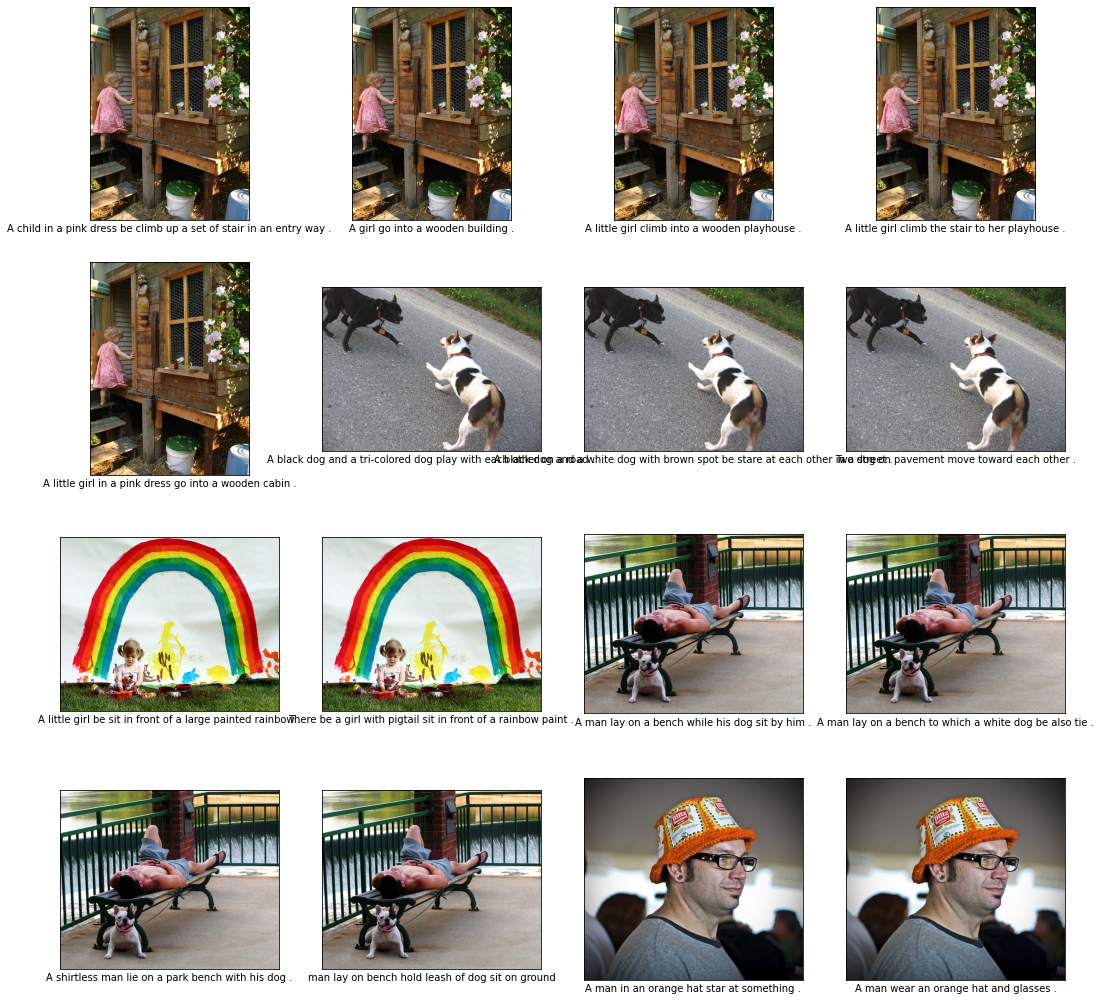

In [12]:
# Plot the Smaple image and its caption from dataset

plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = plt.imread(df["image_path"].iloc[i])
    plt.imshow(img)
    plt.xlabel(df["comment"].iloc[i])
plt.show()

In [13]:
def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

file_list = get_files_from_folder(DRIVE_IMAGE_PATH)
print(len(file_list))

8091


In [14]:
!pip install tweet-preprocessor
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
lemma = nltk.stem.WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
        image_id = doc['image'][i]
        image_desc = doc['comment'][i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

# convert loaded descriptions into vocablury
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()         

In [16]:
clean_text("A cat is sitting over the house # 64")

'a cat is sitting over the house'

In [17]:
df['comment'] = df['comment'].apply(lambda x : clean_text(str(x)))
df.tail()

,image,comment_id,comment,image_path
22900,997338199_7343367d7f.jpg,2,a woman stand near a decorate wall write,/content/drive/MyDrive/Colab_Notebooks/Image/F...
8727,997338199_7343367d7f.jpg,3,wall be cover in gold and pattern,/content/drive/MyDrive/Colab_Notebooks/Image/F...
9063,997722733_0cb5439472.jpg,1,a man be rock climb high in the air,/content/drive/MyDrive/Colab_Notebooks/Image/F...
12504,997722733_0cb5439472.jpg,3,a rock climber in a red shirt,/content/drive/MyDrive/Colab_Notebooks/Image/F...
5976,997722733_0cb5439472.jpg,4,a rock climber practice on a rock climb wall,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [27]:
desc_map = load_decriptions(df) # image name with Its captions
vocabulary = to_vocabluary(desc_map)
print(len(vocabulary))
print(desc_map.get('1042020065_fb3d3ba5ba.jpg'))

5386
['a boy in a green shirt be look down at many inflatable boat', 'a young boy wear a jersey look down over a ledge at many boat in the water', 'a young boy overlook a crowd of inflatable boat', 'a boy look over a railing at the many boat and raft below in the water']


In [30]:
# Total No of words across all the sentences
total_words = []

for key in desc_map.keys():
    [total_words.append(i) for des in desc_map[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 268547


In [32]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
print(len(word_to_idx))
print(len(idx_to_word))

5386
268547


In [33]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))

5386


In [36]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

print(len(total_words)) # 1150 unique words filter, this is going to be new vocab size

1150


In [26]:
max_len = 0 
for key in desc_map.keys():
    for cap in desc_map[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [37]:
save_descriptions(desc_map , f'{DRIVE_PATH}descriptions.txt')

In [20]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img
  
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
#Since we only need image features
model_new = Model(model.input,model.layers[-2].output)

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [21]:
# Testing image encodings
encode_image(DRIVE_IMAGE_PATH+"1000268201_693b08cb0e.jpg")

array([0.0653593 , 0.16782546, 0.32517618, ..., 0.05107123, 0.32821232,
       1.004337  ], dtype=float32)

In [ ]:
# This Step will take around 30 -40  minutes so refrain from running it.
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,rec in enumerate(file_list):
    encoding_train[rec] = encode_image(f'{DRIVE_IMAGE_PATH}{rec}')
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)
df.head()

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

,image,comment_id,comment,image_path
10060,1000268201_693b08cb0e.jpg,0,a child in a pink dress be climb up a set of s...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
9037,1000268201_693b08cb0e.jpg,1,a girl go into a wooden building,/content/drive/MyDrive/Colab_Notebooks/Image/F...
17952,1000268201_693b08cb0e.jpg,2,a little girl climb into a wooden playhouse,/content/drive/MyDrive/Colab_Notebooks/Image/F...
20907,1000268201_693b08cb0e.jpg,3,a little girl climb the stair to her playhouse,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22408,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress go into a wooden...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [ ]:
# Store everything to the disk 
# with open(f"{DRIVE_PATH}encoded_features.pkl","wb") as f:
#     pickle.dump(encoding_train,f)

## Train Test Split

In [40]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15)
print("Shape of training data is",train.shape)
print("Shape of testing data is",test.shape)

Shape of training data is (21250, 4)
Shape of testing data is (3750, 4)


In [42]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train

,image,comment_id,comment,image_path
4043,2275029674_6d4891c20e.jpg,2,two small white dog play,/content/drive/MyDrive/Colab_Notebooks/Image/F...
14719,2875658507_c0d9ceae90.jpg,4,two small brown monkey on a wall fight with ea...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
11189,2995461857_dd26188dcf.jpg,2,an animal run in the middle of a road,/content/drive/MyDrive/Colab_Notebooks/Image/F...
10187,2718495608_d8533e3ac5.jpg,3,a girl wear sunglass smile for the camera,/content/drive/MyDrive/Colab_Notebooks/Image/F...
14793,3169777863_d745865784.jpg,3,men and woman in dark short and top be stretch...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
...,...,...,...,...
16780,3208074567_ac44aeb3f3.jpg,4,a little boy in red be get drench with water,/content/drive/MyDrive/Colab_Notebooks/Image/F...
23270,3019857541_3de3e24f54.jpg,2,a dog be run through a backyard full of leaf,/content/drive/MyDrive/Colab_Notebooks/Image/F...
22068,393987665_91d28f0ed0.jpg,2,a woman in a red jacket look a if she be buy s...,/content/drive/MyDrive/Colab_Notebooks/Image/F...
21072,1797554350_20998753c0.jpg,2,a woman assist a marathon runner by hold an um...,/content/drive/MyDrive/Colab_Notebooks/Image/F...


In [ ]:
# extrat Features
def extract_features(directory):
    
    model = ResNet50(weights="imagenet",input_shape=(224,224,3))
    model.summary()
    
    #remove last layer
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    print(model.summary())
    
    features = dict()
    
    for name in listdir(directory):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))
        
        image = img_to_array(image)
        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))
        
        image = preprocess_input(image)
        
        feature = model.predict(image , verbose = 0)
        
        # get image id
        image_id = name.split(".")[0]
        
        # store features
        features[image_id] = feature
        
        print(name)
        
    return features

In [ ]:
import string
# Load the document file into memory
def load_fp(filename):
  # Open file to read
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text
# get all images with their captions
def img_capt(filename):
  descriptions ={}
  for caption in df[df['image']==filename]['clean_comment1']:
      img, caption = caption.split('t')
      if img[:-2] not in descriptions:
              descriptions[img[:-2]] = [ caption ]
      else:
              descriptions[img[:-2]].append(caption)
  return descriptions
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
      img_caption.replace("-"," ")
      descp = img_caption.split()
      #uppercase to lowercase
      descp = [wrd.lower() for wrd in descp]
      #remove punctuation from each token
      descp = [wrd.translate(table) for wrd in descp]
      #remove hanging 's and a
      descp = [wrd for wrd in descp if(len(wrd)>1)]
      #remove words containing numbers with them
      descp = [wrd for wrd in descp if(wrd.isalpha())]
      #converting back to string
      img_caption = ' '.join(desc)
      captions[img][i]= img_caption
  return captions

def txt_vocab(descriptions):
  # To build vocab of all unique words
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

#To save all descriptions in one file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
            lines.append(key + 't' + desc )
  data = "n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "D:shikhaProject - Image Caption GeneratorFlickr_8k_text"
dataset_images = "/content/drive/MyDrive/Colab_Notebooks/Image/Flicker8k_Dataset/"
#to prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 0
Length of vocabulary =  0
